# By : 𝔄𝔥𝔪𝔢𝔡 𝔄𝔰𝔥𝔯𝔞𝔣

dataset:https://www.kaggle.com/datasets/jbuchner/synthetic-speech-commands-dataset

we'll build Model to use it speech recognition for thirty words

dataset consisting of 41849 audio

# Importing Libraries & Data

In [19]:
import librosa as lr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle as pk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sounddevice as sd
from scipy.io.wavfile import write

In [3]:
dataset='/kaggle/input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset'
pd.DataFrame(os.listdir(dataset),columns=['Files'])

,Files
0,no
1,two
2,four
3,five
4,nine
5,right
6,off
7,yes
8,six
9,dog


In [4]:
def count(path):
    size=[]
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
tr=count(dataset)
tr

,Number Of Sample
no,957
two,902
four,2400
five,1092
nine,1144
right,1276
off,2244
yes,1244
six,1485
dog,1474


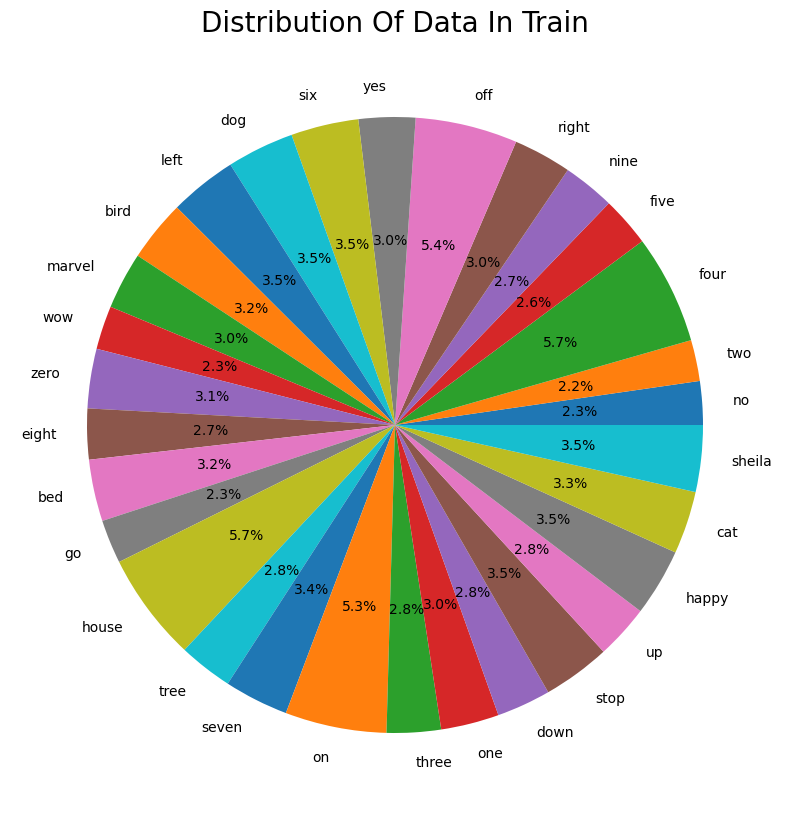

In [5]:
plt.figure(figsize=(10,10))
plt.pie(x='Number Of Sample',labels=os.listdir(dataset),autopct ='%1.1f%%',data=tr)
plt.title('Distribution Of Data In Train',fontsize=20)
plt.show()

Text(0, 0.5, 'Count')

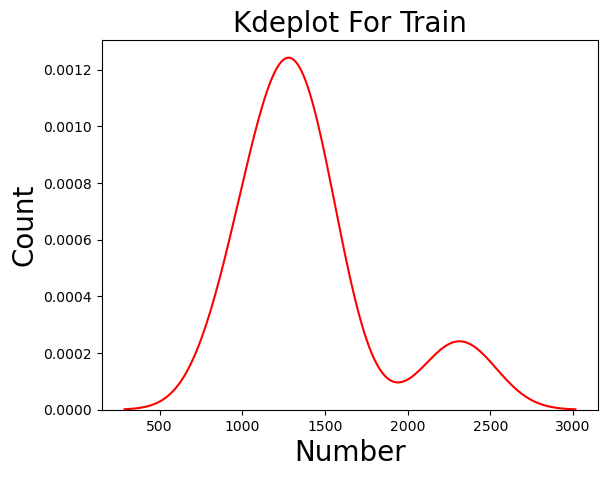

In [6]:
sns.kdeplot(tr['Number Of Sample'], color='red')
plt.title('Kdeplot For Train', fontsize=20)
plt.xlabel('Number', fontsize=20)
plt.ylabel('Count', fontsize=20)

In [7]:
#bed Audio
ipd.Audio('/kaggle/input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset/bed/1014.wav')

In [8]:
#bird Audio
ipd.Audio('/kaggle/input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset/bird/1019.wav')

In [9]:
#cat Audio
ipd.Audio('/kaggle/input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset/cat/1009.wav')

In [10]:
#yes Audio
ipd.Audio('/kaggle/input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset/yes/1014.wav')

In [20]:
def normalize_signal(signal):
    # Calculate the peak amplitude of the signal
    peak_amplitude = np.max(np.abs(signal))
    # Normalize the signal by dividing it by the peak amplitude
    normalized_signal = signal / peak_amplitude
    return normalized_signal

In [12]:
def load(path):
    data=[]
    label=[]
    sample=[]
    for file in os.listdir(path):
        path_=os.path.join(path,file)
        for fil in os.listdir(path_):
            data_contain,sample_rate=lr.load(os.path.join(path_,fil) ,sr=16000)
            data_contain=normalize_signal(data_contain)
            data.append(data_contain)
            sample.append(sample_rate)
            label.append(file)
    return data,label,sample

In [13]:
data,label,sample=load(dataset)
df=pd.DataFrame()
df['Label'],df['sample']=label,sample
df

,Label,sample
0,no,16000
1,no,16000
2,no,16000
3,no,16000
4,no,16000
...,...,...
41844,sheila,16000
41845,sheila,16000
41846,sheila,16000
41847,sheila,16000


# Audio Feature Extraction

In [21]:
#waveform
def waveform(data,sr,label):
    plt.figure(figsize=(14, 5))
    lr.display.waveshow(data, sr=sr)
    plt.suptitle(label)
    plt.title('Waveform plot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
#MFCC features
def mfcc(data, sr):
    mfccs = lr.feature.mfcc(y=data, sr=sr)
    return np.mean(mfccs), mfccs
def mfcc_v(mfccs,label):
    plt.figure(figsize=(10, 4))
    lr.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.suptitle(label)
#Mel-spectrogram
def Mel(data, sr):
    mel_spec = lr.feature.melspectrogram(y=data, sr=sr)
    return np.mean(mel_spec), mel_spec
def mel_v(mel_spec,label,sr):
    # Convert to decibel scale
    mel_spec_db = lr.power_to_db(mel_spec, ref=np.max)
    # Visualize Mel-spectrogram
    plt.figure(figsize=(10, 4))
    lr.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-spectrogram')
    plt.suptitle(label)
#zero_crossing_rate
def zero_crossing(data,sr):
    # Compute zero-crossing rate
    zcr = lr.feature.zero_crossing_rate(data)
    # Print average zero-crossing rate
    avg_zcr = sum(zcr[0])/len(zcr[0])
    print("Average zero-crossing rate:", avg_zcr)
    return zcr
def zero_crossing_v(zcr,label,data,sr):
    time = lr.times_like(zcr)
    # Create waveform plot
    plt.figure(figsize=(14, 5))
    lr.display.waveshow(data, sr=sr, alpha=0.5)
    plt.plot(time, zcr[0], color='r')
    plt.title('Zero-crossing rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.suptitle(label)

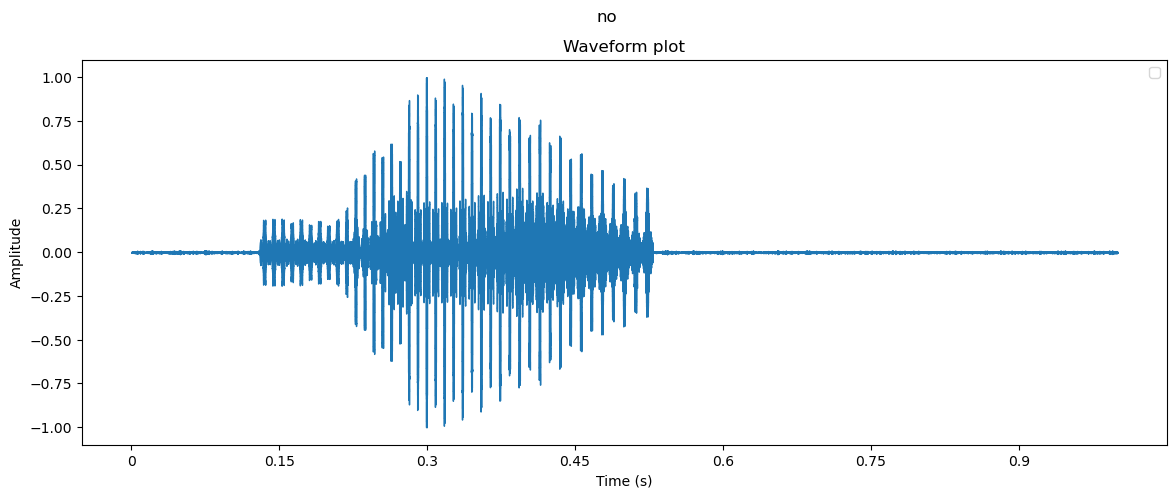

In [15]:
#waveform data[0]
waveform(data[0],sample[0],label[0])
plt.legend()

MFCCs Mean: -11.091337
MFCCs shape: (20, 32)


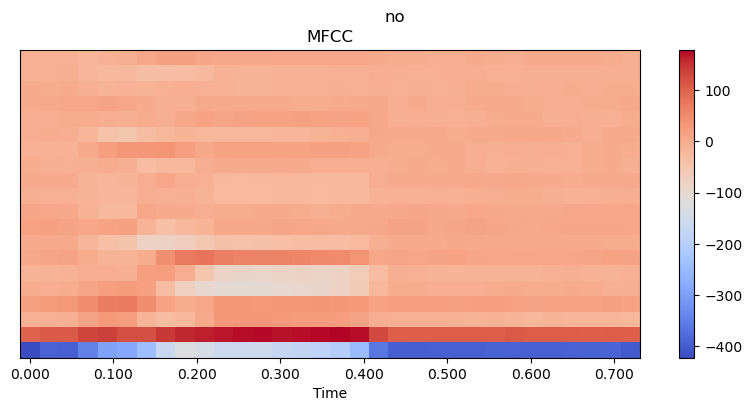

In [16]:
#MFCC data[0]
mfccs_mean, mfccs = mfcc(data[0], sample[0])
print('MFCCs Mean:', mfccs_mean)
print('MFCCs shape:', mfccs.shape)
mfcc_v(mfccs,label[0])

Mel Mean: 4.2114234
Mel : (128, 32)


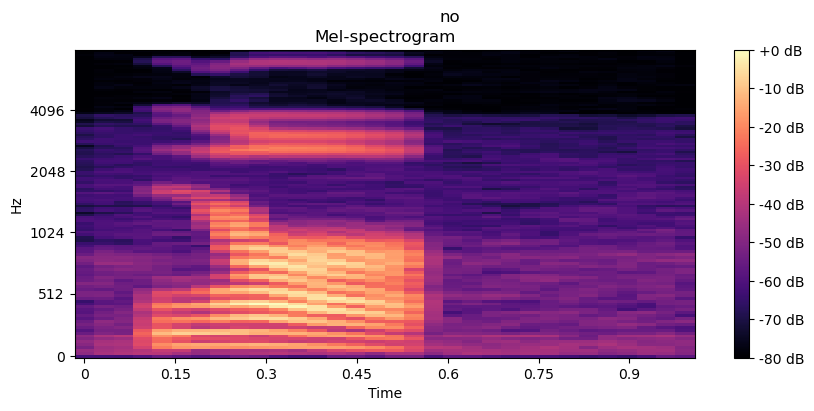

In [17]:
##Mel-spectrogram data[0]
mel_mean,mel=Mel(data[0],sample[0])
print('Mel Mean:',mel_mean)
print('Mel :',mel.shape)
mel_v(mel,label[0],sample[0])

Average zero-crossing rate: 0.0925750732421875
Zcr: (1, 32)


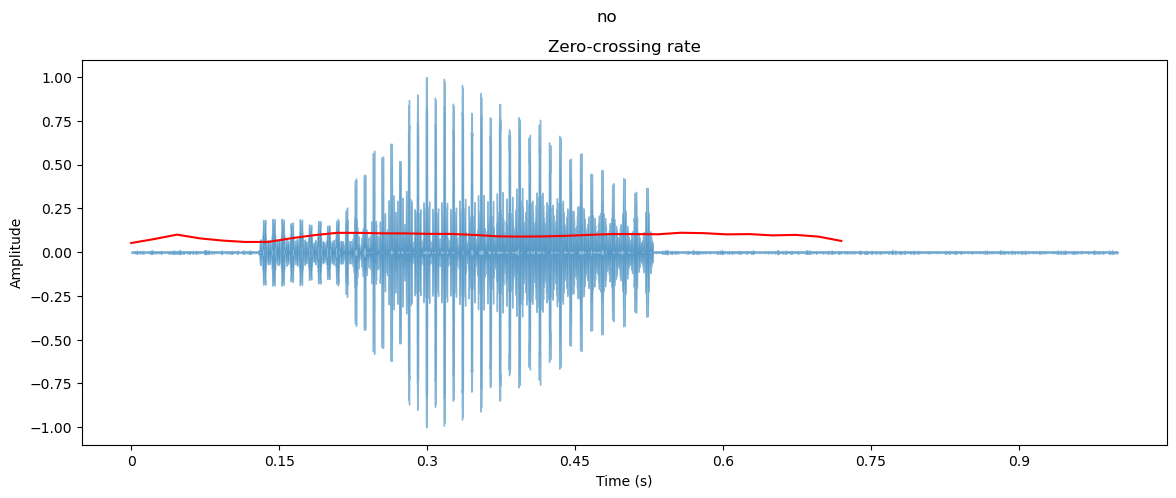

In [18]:
#zero_crossing data[0]
zcr=zero_crossing(data[0],sample[0])
print('Zcr:',zcr.shape)
zero_crossing_v(zcr,label[0],data[0],sample[0])

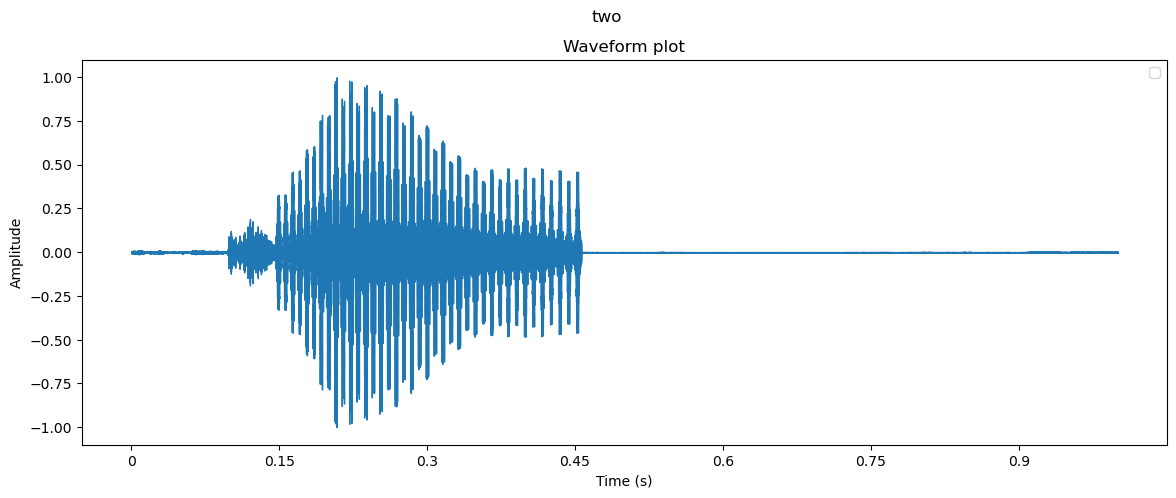

In [19]:
#waveform data[1000]
waveform(data[1000],sample[1000],label[1000])
plt.legend()

MFCCs Mean: -14.039998
MFCCs shape: (20, 32)


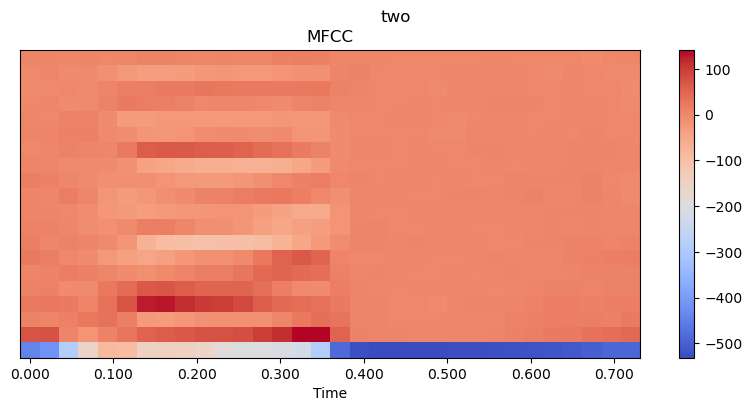

In [20]:
#MFCC data[1000]
mfccs_mean, mfccs = mfcc(data[1000], sample[1000])
print('MFCCs Mean:', mfccs_mean)
print('MFCCs shape:', mfccs.shape)
mfcc_v(mfccs,label[1000])

Mel Mean: 5.561013
Mel : (128, 32)


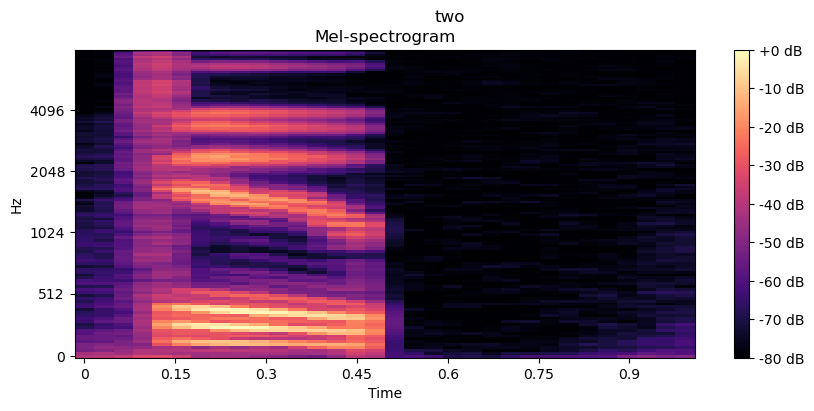

In [21]:
##Mel-spectrogram data[1000]
mel_mean,mel=Mel(data[1000],sample[1000])
print('Mel Mean:',mel_mean)
print('Mel :',mel.shape)
mel_v(mel,label[1000],sample[1000])

Average zero-crossing rate: 0.189971923828125
Zcr: (1, 32)


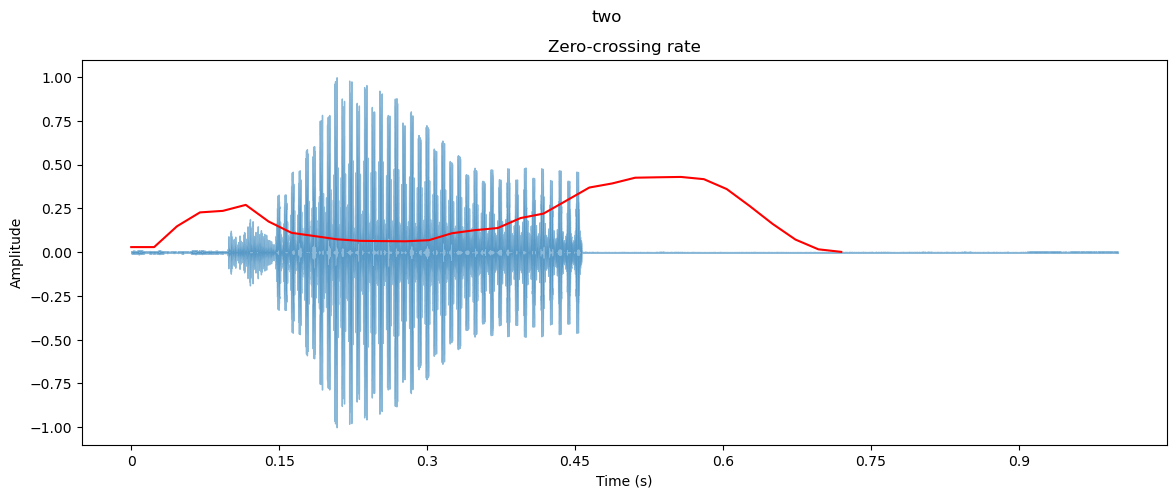

In [22]:
#zero_crossing data[1000]
zcr=zero_crossing(data[1000],sample[1000])
print('Zcr:',zcr.shape)
zero_crossing_v(zcr,label[1000],data[1000],sample[1000])

In [23]:
code={}
x=0
for i in pd.unique(label):
    code[i]=x
    x+=1
pd.DataFrame(code.values(),columns=['Value'],index=code.keys())   

,Value
no,0
two,1
four,2
five,3
nine,4
right,5
off,6
yes,7
six,8
dog,9


In [24]:
def get_Name(N):
    for x,y in code.items():
          if y==N:
                return x
for i in range(len(label)):
    label[i]=code[label[i]]
pd.DataFrame(label,columns=['Labels'])    

,Labels
0,0
1,0
2,0
3,0
4,0
...,...
41844,29
41845,29
41846,29
41847,29


# Splitting Data

In [25]:
data=np.array(data).reshape(-1,16000,1)
label=np.array(label)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (37664, 16000, 1)
X_test shape is  (4185, 16000, 1)
y_train shape is  (37664,)
y_test shape is  (4185,)


# Model Building 

In [26]:
num_class=len(pd.unique(label))
model=keras.Sequential()
model.add(keras.layers.Conv1D(filters=8, kernel_size=13,activation=tf.nn.relu,input_shape=(16000,1)))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=16, kernel_size=11,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=32, kernel_size=9,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv1D(filters=64, kernel_size=7,activation=tf.nn.relu))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(num_class,activation=tf.nn.softmax))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15988, 8)          112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5329, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5329, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5319, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1773, 16)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1773, 16)          0

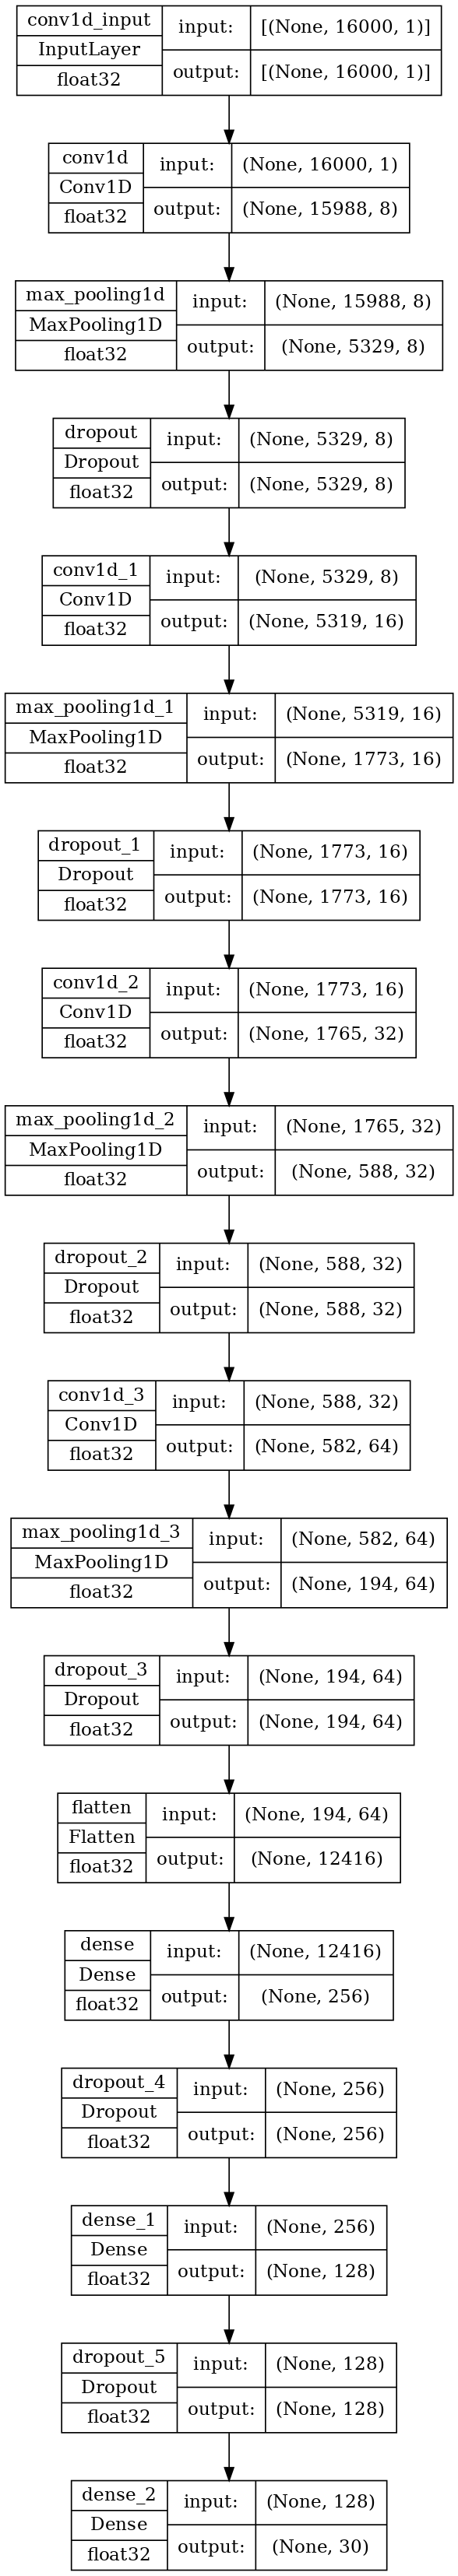

In [28]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [29]:
model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
hist=model.fit(X_train,y_train,epochs=30)

Epoch 1/30
1177/1177 [==============================] - 32s 12ms/step - loss: 1.5557 - accuracy: 0.5167
Epoch 2/30
1177/1177 [==============================] - 14s 12ms/step - loss: 0.5100 - accuracy: 0.8323
Epoch 3/30
1177/1177 [==============================] - 14s 12ms/step - loss: 0.3160 - accuracy: 0.8960
Epoch 4/30
1177/1177 [==============================] - 14s 12ms/step - loss: 0.2346 - accuracy: 0.9237
Epoch 5/30
1177/1177 [==============================] - 14s 12ms/step - loss: 0.1852 - accuracy: 0.9403
Epoch 6/30
1177/1177 [==============================] - 15s 12ms/step - loss: 0.1742 - accuracy: 0.9442
Epoch 7/30
1177/1177 [==============================] - 14s 12ms/step - loss: 0.1445 - accuracy: 0.9541
Epoch 8/30
1177/1177 [==============================] - 14s 12ms/step - loss: 0.1329 - accuracy: 0.9578
Epoch 9/30
1177/1177 [==============================] - 15s 13ms/step - loss: 0.1120 - accuracy: 0.9655
Epoch 10/30
1177/1177 [==============================] - 15s 12m

In [30]:
loss,acc=model.evaluate(X_test,y_test)
print('Loss is :',loss)
print('ACC is :',acc)

131/131 [==============================] - 1s 7ms/step - loss: 0.0399 - accuracy: 0.9873
Loss is : 0.03993929550051689
ACC is : 0.987335741519928


In [31]:
hist_=hist.history
pd.DataFrame(hist_)

,loss,accuracy
0,1.555650,0.516700
1,0.510034,0.832254
2,0.316044,0.896001
3,0.234600,0.923720
4,0.185156,0.940288
5,0.174229,0.944191
6,0.144463,0.954147
7,0.132929,0.957758
8,0.111958,0.965458
9,0.114787,0.964422


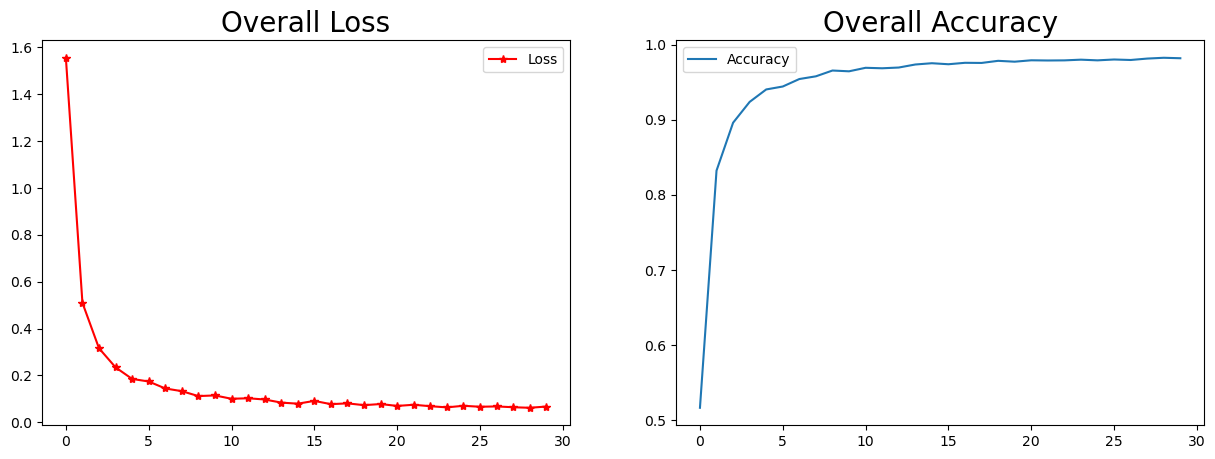

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],c='r',marker='*',label='Loss')
plt.title('Overall Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Accuracy')
plt.title('Overall Accuracy',fontsize=20)
plt.legend()

In [33]:
predict=model.predict(X_test)
predict[0]

131/131 [==============================] - 1s 4ms/step


array([0.00000000e+00, 0.00000000e+00, 6.82609664e-16, 3.95227156e-30,
       0.00000000e+00, 1.07636414e-16, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.67130751e-16, 4.06391250e-21, 1.37165793e-24,
       8.30585484e-26, 0.00000000e+00, 0.00000000e+00, 1.44680672e-36,
       1.39338323e-28, 0.00000000e+00, 2.03434557e-12, 0.00000000e+00,
       0.00000000e+00, 1.05510245e-31, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.45820959e-16, 2.09242990e-32,
       3.85402810e-27, 0.00000000e+00], dtype=float32)

In [34]:
preN=[]
prename=[]
for row in predict:
    N=np.argmax(row)
    preN.append(N)
    prename.append(get_Name(N))
pd.DataFrame(prename,columns=['Predictions'])

,Predictions
0,off
1,down
2,marvel
3,happy
4,happy
...,...
4180,five
4181,four
4182,house
4183,yes


In [35]:
predict=[]
y_act=[]
for p in range(30):
    y_act.append(get_Name(y_test[p]))
    predict.append(prename[p])
pd_p=pd.DataFrame(y_act,columns=['y_act'])  
pd_p['predict']=predict
pd_p

,y_act,predict
0,off,off
1,down,down
2,marvel,marvel
3,happy,happy
4,happy,happy
5,zero,zero
6,on,on
7,dog,dog
8,house,house
9,zero,zero


# Model Check

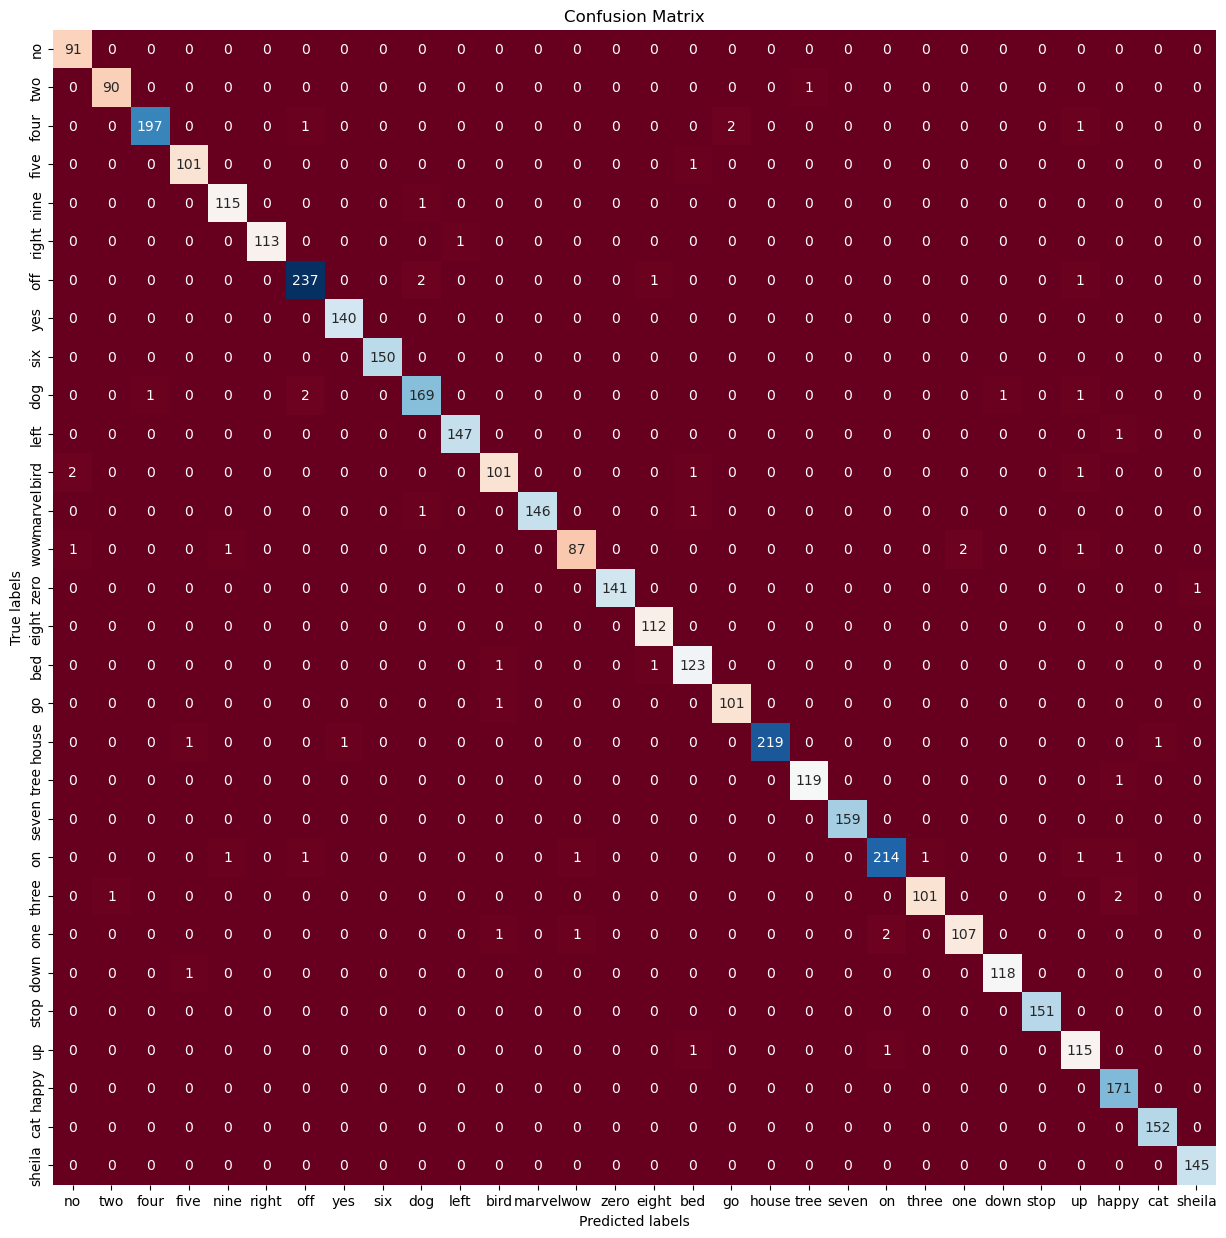

array([[ 91,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,  90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0, 197,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0],
       [  0,   0,   0, 101,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0, 115,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 113,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,

In [36]:
plt.figure(figsize=(15,15))
ax= plt.subplot()
CM = confusion_matrix(y_test, preN)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(code.keys()) 
ax.yaxis.set_ticklabels(code.keys())
plt.show()
CM

In [37]:
ClassificationReport = classification_report(y_test,preN)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.97      1.00      0.98        91
           1       0.99      0.99      0.99        91
           2       0.99      0.98      0.99       201
           3       0.98      0.99      0.99       102
           4       0.98      0.99      0.99       116
           5       1.00      0.99      1.00       114
           6       0.98      0.98      0.98       241
           7       0.99      1.00      1.00       140
           8       1.00      1.00      1.00       150
           9       0.98      0.97      0.97       174
          10       0.99      0.99      0.99       148
          11       0.97      0.96      0.97       105
          12       1.00      0.99      0.99       148
          13       0.98      0.95      0.96        92
          14       1.00      0.99      1.00       142
          15       0.98      1.00      0.99       112
          16       0.97      0.98      0.98       125

# Save Model

In [38]:
model.save('/kaggle/working/speech_model.h5')

# REAL TRIAL

In [22]:
code={
'no':0,'two':1,'four':2,'five':3,'nine':4,
'right':5,'off':6,'yes':7,'six':8,'dog':9,'left':10,'bird':11,'marvel':12,'wow':13
,'zero':14,'eight':15,'bed':16,'go':17,'house':18,'tree':19,'seven':20,'on':21,
'three':22,'one':23,'down':24,'stop':25,'up':26,'happy':27,'cat':28,'sheila':29}
def get_Name(N):
    for x,y in code.items():
          if y==N:
                return x

In [23]:
def record():
    sample_rate=16000
    duration=1
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    write("recording.wav", sample_rate, recording)

In [24]:
def predict():
    data, sr = lr.load("recording.wav",sr=16000)
    data=normalize_signal(data)
    data=data.reshape(-1,16000,1)
    savedmodel=keras.models.load_model('speech_model.h5')
    pred=savedmodel.predict(data)
    for row in pred:
        N=np.argmax(row)
    print(get_Name(N))

In [25]:
record()

In [26]:
ipd.Audio("recording.wav")

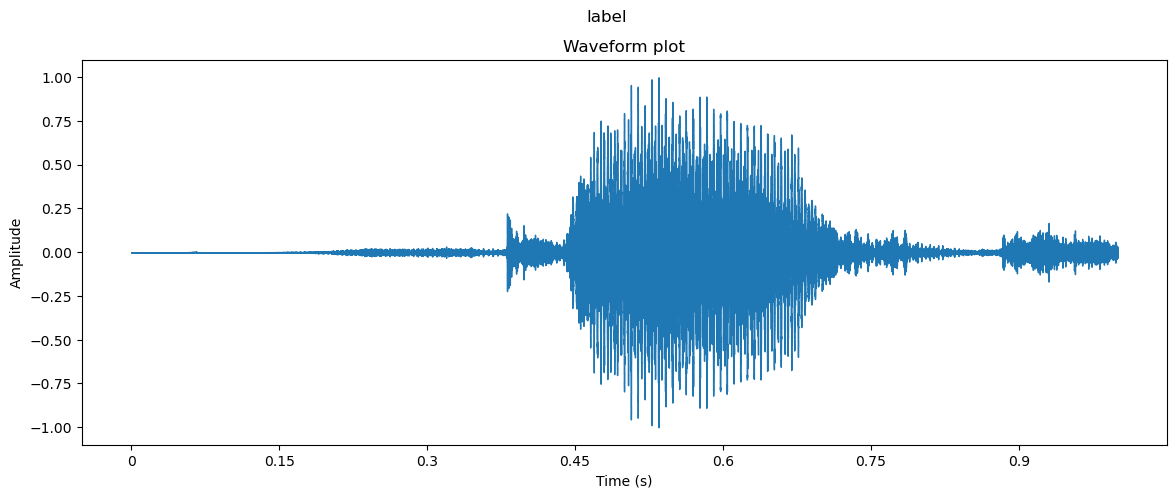

In [27]:
#waveform data
data, sr = lr.load("recording.wav",sr=16000)
data=normalize_signal(data)
waveform(data,sr,'label')

MFCCs Mean: -10.103216
MFCCs shape: (20, 32)


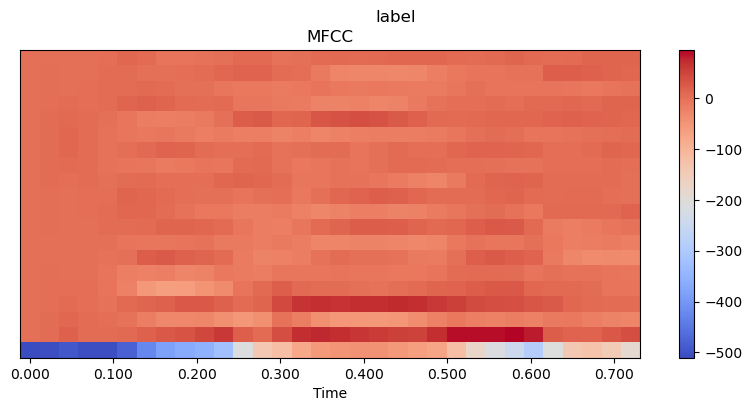

In [28]:
#MFCC data[0]
mfccs_mean, mfccs = mfcc(data, sr)
print('MFCCs Mean:', mfccs_mean)
print('MFCCs shape:', mfccs.shape)
mfcc_v(mfccs,'label')

Mel Mean: 6.7323656
Mel : (128, 32)


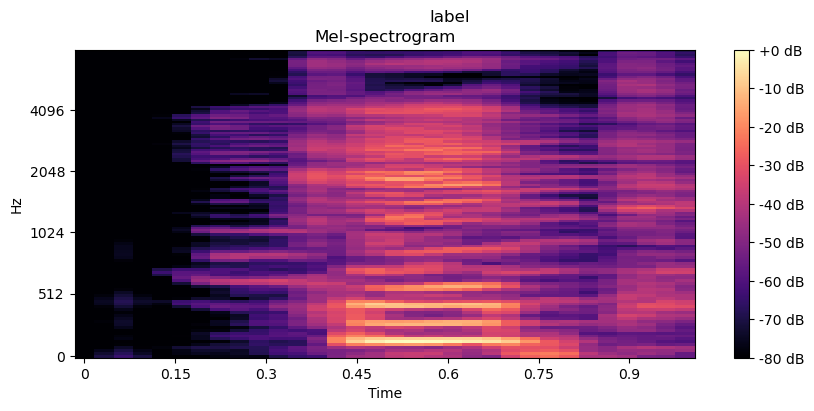

In [29]:
mel_mean,mel=Mel(data,sr)
print('Mel Mean:',mel_mean)
print('Mel :',mel.shape)
mel_v(mel,'label',sr)

Average zero-crossing rate: 0.167999267578125
Zcr: (1, 32)


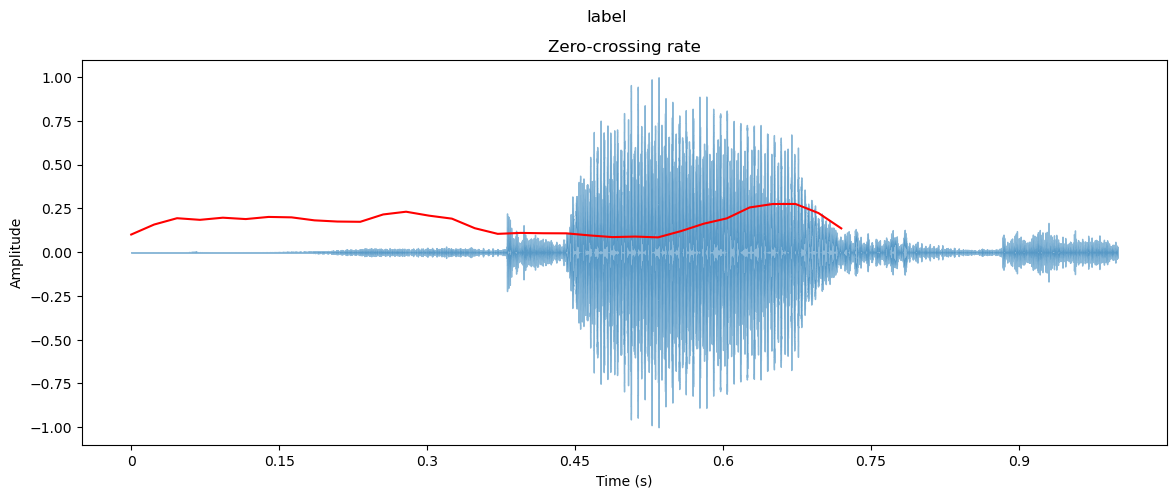

In [30]:
#zero_crossing data
zcr=zero_crossing(data,sr)
print('Zcr:',zcr.shape)
zero_crossing_v(zcr,'label',data,sr)

In [31]:
predict()

1/1 [==============================] - 0s 194ms/step
happy


# GOOD LUCK🤞🤞
Prof.Dr.𝔄𝔥𝔪𝔢𝔡 𝔄𝔰𝔥𝔯𝔞𝔣